In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


## 確認裝置

In [32]:
# 1. 裝置設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用裝置：{device}")

使用裝置：cuda:0


## 下載資料集

In [36]:
# 2. 資料前處理與載入
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),              # 隨機裁切 (保持 32x32)
    transforms.RandomHorizontalFlip(),                 # 隨機水平翻轉
    transforms.ColorJitter(brightness=0.2, 
                           contrast=0.2, 
                           saturation=0.2),           # 顏色抖動
    transforms.RandomRotation(15),                     # 小角度旋轉
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),     # 平均值
                         (0.2023, 0.1994, 0.2010)),   # 標準差
    # transforms.ToTensor(),  # 直接將像素從 [0,255] => [0,1]
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)


In [37]:

class CNN2(nn.Module):
    def __init__(self, num_classes=10, dropout_p=0.6):
        super().__init__()
        act = nn.ReLU()  # 或改成 nn.GELU()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 32x32 -> 32x32
            nn.BatchNorm2d(64),
            act,
            nn.MaxPool2d(2, 2)                           # 32x32 -> 16x16
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# 16x16 -> 16x16
            nn.BatchNorm2d(128),
            act,
            nn.MaxPool2d(2, 2)                           # 16x16 -> 8x8
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            act,
            nn.MaxPool2d(2, 2)                           
        )

        self.gap = nn.AdaptiveAvgPool2d(1)  # 8x8 -> 1x1
        self.dropout = nn.Dropout(dropout_p) # dropout，避免 overfitting
        #self.fc1 = nn.Linear(64, num_classes)
        #self.fc1 = nn.Linear(128, num_classes)
        self.fc1 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.block1(x)   # (B,64,16,16)
        x = self.block2(x)   # (B,128,8,8)
        x = self.block3(x)
        x = self.gap(x)      # (B,256,1,1)
        x = x.view(x.size(0), -1)  # (B,256)
        x = self.dropout(x)
        x = self.fc1(x)      # (B,num_classes)
        return x
    
model2 = CNN2().to(device)
print(model2)

# 4. 損失與優化器
criterion = nn.CrossEntropyLoss()  # 直接接收整數標籤
optimizer = optim.Adam(model2.parameters(), lr=0.0005, weight_decay=1e-4)
#optimizer = optim.SGD(model2.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


CNN2(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=1)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc1): Linear(in_features=2

Epoch 1/90 — Train Loss: 1.7677, Train Acc: 0.3391 — Val Loss: 1.6263, Val Acc: 0.3853
Epoch 2/90 — Train Loss: 1.5110, Train Acc: 0.4468 — Val Loss: 1.4852, Val Acc: 0.4704
Epoch 3/90 — Train Loss: 1.4137, Train Acc: 0.4844 — Val Loss: 1.3092, Val Acc: 0.5257
Epoch 4/90 — Train Loss: 1.3446, Train Acc: 0.5135 — Val Loss: 1.2533, Val Acc: 0.5606
Epoch 5/90 — Train Loss: 1.2955, Train Acc: 0.5335 — Val Loss: 1.2707, Val Acc: 0.5322
Epoch 6/90 — Train Loss: 1.2562, Train Acc: 0.5492 — Val Loss: 1.2117, Val Acc: 0.5630
Epoch 7/90 — Train Loss: 1.2273, Train Acc: 0.5619 — Val Loss: 1.6125, Val Acc: 0.4851
Epoch 8/90 — Train Loss: 1.1913, Train Acc: 0.5742 — Val Loss: 1.2937, Val Acc: 0.5419
Epoch 9/90 — Train Loss: 1.1611, Train Acc: 0.5867 — Val Loss: 1.2048, Val Acc: 0.5754
Epoch 10/90 — Train Loss: 1.1495, Train Acc: 0.5917 — Val Loss: 1.1563, Val Acc: 0.5920
Epoch 11/90 — Train Loss: 1.1296, Train Acc: 0.6005 — Val Loss: 1.1202, Val Acc: 0.5948
Epoch 12/90 — Train Loss: 1.1081, Train A

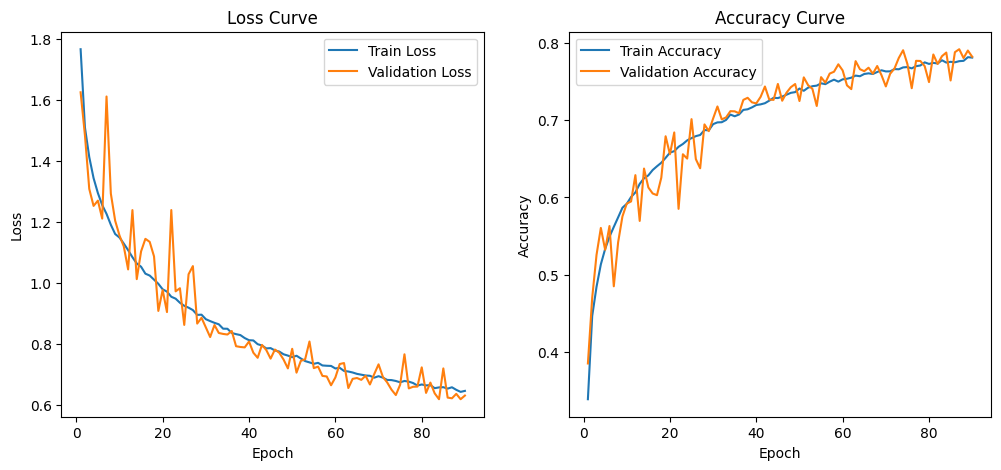

In [38]:
import matplotlib.pyplot as plt

num_epochs = 90

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    # ====== 訓練 ======
    model2.train()
    running_loss = 0.0
    correct, total = 0, 0

    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ====== 驗證 ======
    model2.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model2(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_running_loss / len(testloader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} — "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# ====== 畫 Loss 曲線 ======
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# ====== 畫 Accuracy 曲線 ======
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()
